# **Stable Diffusion** 🎨 
*...usando `🧨diffusers`*

Stable Diffusion es un modelo de difusión latente de texto a imagen creado por investigadores e ingenieros de [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) y [LAION](https://laion.ai/). Está entrenado en imágenes de 512x512 de un subconjunto del dataset [LAION-5B](https://laion.ai/blog/laion-5b/). Este modelo utiliza un codificador de texto CLIP ViT-L/14 congelado para condicionar el modelo en las indicaciones de texto. Con su codificador de texto 860M UNet y 123M, el modelo es relativamente liviano y se ejecuta en una GPU con al menos 10 GB de VRAM.
Ver la [model card](https://huggingface.co/CompVis/stable-diffusion) para mas informacion.
Este notebook de Colab muestra cómo usar Stable Diffusion con la libreria de 🤗 Hugging Face [🧨 Diffusers](https://github.com/huggingface/diffusers). 

¡Empecemos!

## Cómo utilizar `StableDiffusionPipeline`

Antes de sumergirnos en los aspectos teóricos de cómo funciona  Stable Diffusion,
probemos un poco 🤗.

En esta sección, mostramos cómo puede ejecutar la inferencia de texto a imagen en solo unas pocas líneas de código.

### Configuración

Primero, hay que asegurarse de estar usando un entorno de ejecución GPU para ejecutar este notebook, de modo que la inferencia sea mucho más rápida. Si el siguiente comando falla, use el menú `entorno de ejecución` del menu y seleccione `Cambiar tipo de entorno ejecución`.

Chequeamos la tarjeta gráfica 

In [1]:
!nvidia-smi

Mon Nov 28 18:03:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Stable Diffusion Pipeline

`StableDiffusionPipeline` es una end-to-end inference pipeline que se puede usar para generar imágenes a partir de texto con solo unas pocas líneas de código.

En el siguiente paso tenemos que instalar los paquetes necesarios y configuramos el entorno. Elegimos que version usar y los instalamos en funcion de esa seleccion

Si elige el modelo `v1-4` se debe aceptar la licencia del modelo antes de descargarlo o usarlo. Por lo que hay que ir a [la pagina](https://huggingface.co/CompVis/stable-diffusion-v1-4) leer la licencia y marcar la casilla de verificación si está de acuerdo.

Tienes que ser un usuario registrado en 🤗 Hugging Face Hub, y también necesitarás usar un token de acceso para que el código funcione. Para obtener más información sobre los tokens de acceso, consulte [esta sección de la documentación](https://huggingface.co/docs/hub/security-tokens).

Creamos un token para esta aplicacion, le damos el nombre que deseamos para identificarlo y luego lo copiamos para usarlo mas abajo cuando sea necesario autentificar

In [2]:
#@markdown **Seleccionamos el modelo a descargar**
from IPython.display import clear_output

Model_Version = "V2.0" #@param ["V2.0", "V1.4"]

if Model_Version == "V1.4":
  !pip install diffusers==0.4.0
  !pip install transformers scipy ftfy
  !pip install "ipywidgets>=7,<8"

elif Model_Version == "V2.0":
  !pip install --upgrade git+https://github.com/huggingface/diffusers.git transformers accelerate scipy

# Paquetes necesarios para la traduccion
!pip install sentencepiece
!pip install sacremoses

clear_output()

print("Paquetes instalados correctamente")

Paquetes instalados correctamente


El siguiente paso es cargar los modelos. Si la version `v1-4` fue elegida, se le solicitará iniciar sesión con su token de usuario de 🤗

In [3]:
#@title Ejecutar la siguiente linea de codigo para cargar los modelos
from diffusers import StableDiffusionPipeline
# from huggingface_hub import notebook_login
from transformers import pipeline
import torch
from IPython.display import clear_output


if Model_Version == "V1.4":
#  notebook_login()
  model_name = "CompVis/stable-diffusion-v1-4"
  pipe = StableDiffusionPipeline.from_pretrained(model_name, revision="fp16", torch_dtype=torch.float16)  

elif Model_Version == "V2.0":
  from diffusers import EulerDiscreteScheduler
  model_name = "stabilityai/stable-diffusion-2"
  scheduler = EulerDiscreteScheduler.from_pretrained(model_name, subfolder="scheduler")
  pipe = StableDiffusionPipeline.from_pretrained(model_name, scheduler=scheduler, revision="fp16", torch_dtype=torch.float16)

# Movemos el pipeline a GPU para tener una inferencia más rápida.
pipe = pipe.to("cuda")
pipe.enable_attention_slicing() 

# Cargamos el modelo traductor y creamos el pipeline para traducir al ingles
spanish_model_name = "Helsinki-NLP/opus-mt-es-en"
translator_es_en = pipeline("translation", model=spanish_model_name)

clear_output()


## Configuramos google colab

Como google colab ha deshabilitado los widgets externos, debemos habilitarlo explícitamente.

Ejecutamos la siguiente celda para habilitar

In [4]:
from google.colab import output
output.enable_custom_widget_manager()

  0%|          | 0/51 [00:00<?, ?it/s]

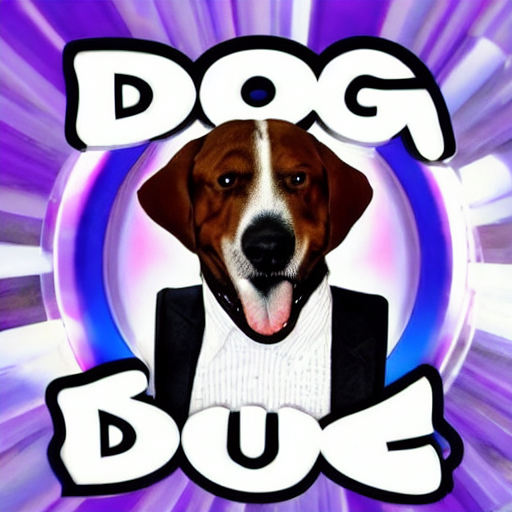

In [5]:
#@markdown **Seleccionamos el idioma de entrada del prompt para generar las imagnes**

idioma = "Spanish" #@param ["Spanish", "English"]

if idioma== "Spanish":
  #@markdown Cargamos el prompt en español si idioma "Spanish" esta seleccionado
  prompt_es = "Un perro dj" #@param {type:"string"}
  english_text = translator_es_en(prompt_es)
  prompt_en = english_text[0]['translation_text']
elif idioma== "English":
  #@markdown Cargamos el prompt en inglés si idioma "English" esta seleccionado
  prompt_en = "" #@param {type:"string"}

image = pipe(prompt_en).images[0]

# Visualizamos la imagen. En el proximo cuadro de codigo podemos guardarla
image

## Opcional: Guardamos la imagen generada
En este paso Creamos una carpeta llamada "imagenes" donde guardaremos los outputs. Si conectamos con drive le damos el path a la carpeta donde queremos almacenar las imagenes. De lo contrario podemos crear una carpeta temporal donde vamos guardando las imagenes pero recordar que cuando el entorno de ejecucion se desconecte perderemos todo lo guardado


Tambien podemos habilitar, si deseamos, la conexion de google colab con nustro drive. Esto nos servira para ir dejando aqui guardadas las imagenes que generemos. Tenemos que habilitar el permiso en las ventanas emergentes al correr el siguiente codigo

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [25]:
import os

#@markdown Agregar el path al drive donde quieres que se genere la carpeta "imagenes. Si ya existe la preserva como esta.
folder_path = "/content/gdrive/MyDrive/imagenes_sd'" #@param {type:"string"}

# Creamos la carpeta
os.makedirs(folder_path, exist_ok=True)

# Guardamos la imagen
#@markdown Agregar el nombre con el que se desea almacenar la imagen. Si no es provisto por defecto lo guardara con el prompt en inglés
imagen_name = "imagen_sd" #@param {type:"string"}

# Chequeamos para no sobreescribir
i=1
def check_dir(image_name, i):
  files = os.listdir(folder_path)
  name = '{}.png'.format(image_name)
  if name in files:
    image_name = "{}_{}".format(image_name, i)
    i+=1
    image_name = check_dir(image_name, i)
  return image_name

if len(imagen_name)>0:
  imagen_name = check_dir(imagen_name,i)
else: 
  imagen_name = prompt_en
  imagen_name = check_dir(imagen_name,i)
# La guardamos
image.save('{}/{}.png'.format(folder_path,imagen_name))

print("{} guardada con exito".format(imagen_name))

['perro dj.png', 'perro dj_1.png', 'perro dj_1_2.png', 'perro dj_1_2_3.png', 'perro.png', 'A dog dj.png']
['perro dj.png', 'perro dj_1.png', 'perro dj_1_2.png', 'perro dj_1_2_3.png', 'perro.png', 'A dog dj.png']
A dog dj_1 guardada con exito
